In [1]:
import os 

os.environ["SPICEROOT"] = "/Users/krodriguez/isisdata/"
os.environ["ISISDATA"] = os.environ["SPICEROOT"]
os.environ["SPICEQL_CACHE_DIR"] = "/Users/krodriguez/spiceql-cache/"

# os.environ["SPICEQL_LOG_LEVEL"] = "TRACE"

import pprint
from osgeo import gdal
import pyspiceql as pql
import urllib
import plio 
import matplotlib
from matplotlib import pyplot as plt
import numpy as np 
from dateutil import parser

# Get Start and Stop Times 

In [198]:
startet = pql.utcToEt("2019-01-01")
stopet = pql.utcToEt("2019-01-02")
# get an array of times in regular intervals throughout the exposure 
ets = np.linspace(start=startet, stop=stopet, num=1000)
print("num ets:", len(ets))
dates = [parser.parse(pql.etToUtc(et, searchKernels=False)) for et in ets]
startet, stopet

num ets: 1000


(599572869.1839148, 599659269.1839437)

# Search for Appropriate Kernels

Spiceql will load them for us if we use `searchKernels=True` later when getting the rotations, but here we will load them manually so we know exactly what kernels are being used.

In [199]:
# Get all Base kernels, not really worried about being minimal 
cfg = pql.Config()
base_kernels = pql.getLatestKernels(cfg["base"].get())
print("Base kernels Used")
pprint.pprint(base_kernels)

# furnish the kernels found
base_set = pql.KernelSet(base_kernels)

# Get appropriate LROC kernels
cfg = pql.Config()
lroc_kernels = cfg["lroc"].get()
lroc_kernels = pql.getLatestKernels(pql.searchMissionKernels(lroc_kernels, ets, False))
print("LROC kernels Used")
pprint.pprint(lroc_kernels)

# furnish the kernels found
lroc_set = pql.KernelSet(lroc_kernels)

Base kernels Used
{'lsk': {'kernels': [['/Users/krodriguez/isisdata//base/kernels/lsk/naif0012.tls']]},
 'pck': {'kernels': [['/Users/krodriguez/isisdata//base/kernels/pck/pck00009.tpc']]},
 'spk': {'kernels': [['/Users/krodriguez/isisdata//base/kernels/spk/de430.bsp'],
                     ['/Users/krodriguez/isisdata//base/kernels/spk/mar097.bsp'],
                     ['/Users/krodriguez/isisdata//base/kernels/spk/nep090.bsp'],
                     ['/Users/krodriguez/isisdata//base/kernels/spk/sat425.bsp'],
                     ['/Users/krodriguez/isisdata//base/kernels/spk/ura115.bsp']]}}
LROC kernels Used
{'ck': {'reconstructed': {'kernels': [['/Users/krodriguez/isisdata//lro/kernels/ck/lrolc_2018334_2019001_v01.bc'],
                                      ['/Users/krodriguez/isisdata//lro/kernels/ck/lrolc_2018365_2019032_v01.bc'],
                                      ['/Users/krodriguez/isisdata//lro/kernels/ck/moc42r_2018334_2019001_v01.bc'],
                                   

# Get orientations and convert to Euler Angles

In [200]:
def quaternion_to_ypr(quats):
    qw, qx, qy, qz = orientations[:,:4].transpose()
    
    yaw = np.degrees(np.arctan2(2.0*(qy*qz + qw*qx), qw*qw - qx*qx - qy*qy + qz*qz));
    pitch = np.degrees(np.arcsin(-2.0*(qx*qz - qw*qy)));
    roll = np.degrees(np.arctan2(2.0*(qx*qy + qw*qz), qw*qw + qx*qx - qy*qy - qz*qz));
    return yaw, pitch, roll


# get orientations relative to the moon 
inst_frame = pql.translateNameToCode("LRO_LROCNACL", "lro")
target_frame = pql.translateNameToCode("IAU_MOON", "base")

print("Instrument Frame: ", inst_frame)
print("Target Frame: ", target_frame)

orientations = pql.getTargetOrientations(ets, -85000, target_frame, "lro", "reconstructed", False)
orientations = np.asarray(orientations)

yaw, pitch, roll = quaternion_to_ypr(orientations)

Instrument Frame:  -85600
Target Frame:  10020


# Use Matplotlib to Make Some Basic Plots

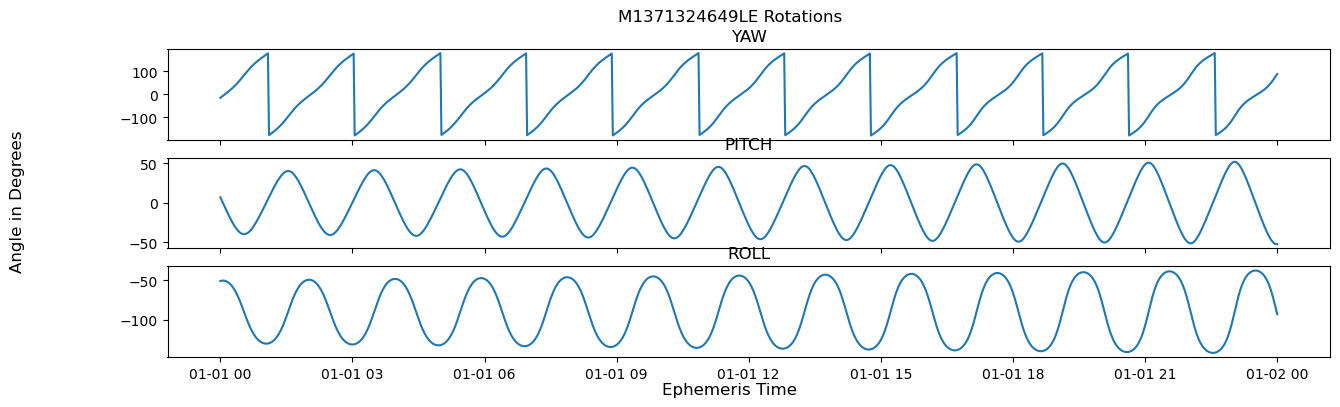

In [201]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.suptitle(f'{image_id} Rotations')
fig.set_figheight(4)
fig.set_figwidth(15)
ax1.plot(dates, yaw)
ax1.set_title("YAW")
ax2.plot(dates, pitch)
ax2.set_title("PITCH")
ax3.plot(dates, roll)
ax3.set_title("ROLL")
fig.supxlabel("Ephemeris Time")
fig.supylabel("Angle in Degrees")
plt.show()

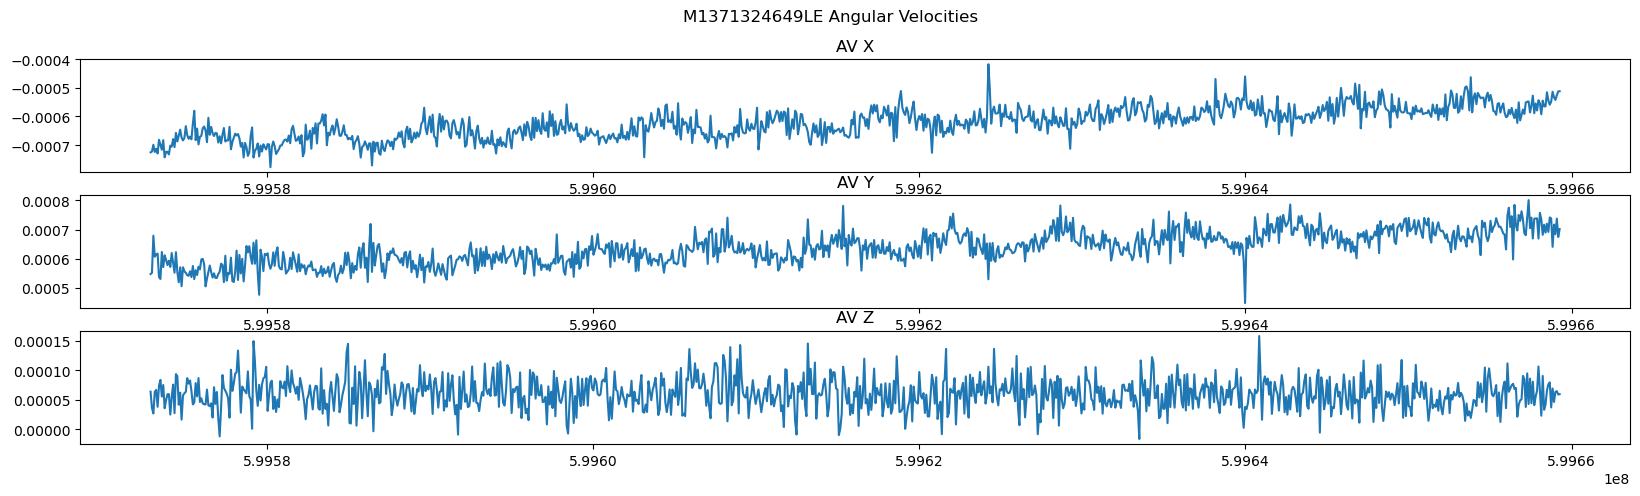

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle(f'{image_id} Angular Velocities')
fig.set_figheight(5)
fig.set_figwidth(20)
ax1.plot(ets, orientations[:, 4])
ax1.set_title("AV X")
ax2.plot(ets, orientations[:, 5])
ax2.set_title("AV Y")
ax3.plot(ets, orientations[:, 6])
ax3.set_title("AV Z")
plt.show()